# Video Segmentation Challenge
----------------------
Group - King-Fish

In [2]:
# needed imports
import numpy as np
import os
import GPUtil

import cv2

seed = 1234 # seed to make the notebook reproducible
np.random.seed(seed)

# machine learning / deep learning
from sklearn.model_selection import train_test_split 

# deep learning library
import keras
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, Activation, Dropout, BatchNormalization, UpSampling2D
from keras.optimizers import Adam
from keras import Model
from keras.utils.training_utils import multi_gpu_model

# machine learning / deep learning
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.log_device_placement = True
sess = tf.Session(config=config)

# plotting images
import matplotlib.pyplot as plt

from PatchGeneratorPaul import PatchGenerator
from PrintData import PrintData
from create_model import createVGG16, createVGGskip

Using TensorFlow backend.


In [3]:
# directory containing the images and labelss
#file_dir = 'gs://king-fish-bucket'
file_dir = './data/full_data/b/processedData'
#file_dir = './data/processedData'

# change :8 to :7 when using the whole dataset
# -8: too


file_dirs_color = sorted(os.listdir(file_dir))[:7]
file_dirs_label = sorted(os.listdir(file_dir))[-7:]

In [4]:
# directory to store the resulting models
result_dir = './results'
if not os.path.exists(result_dir):
    os.mkdir(result_dir)

Class labels: 
- car, 33
- motorbicycle, 34 
- bicycle, 35
- person, 36 
- truck, 38 
- bus, 39 
- tricycle, 40
- unknown, 0

In [5]:
# numpy array containing all the classes
class_labels = np.array((33, 34, 35, 36, 38, 39, 40, 0))
#class_labels = np.array((33, 34, 35, 36, 0))

In [6]:
# obtain a list of files in the given directory
filelist_x = np.array(sorted(os.listdir(os.path.join(file_dir, file_dirs_color[3]))))
filelist_y = np.array(sorted(os.listdir(os.path.join(file_dir, file_dirs_label[3]))))

## Test that the images can be loaded

In order to assure that everything works, some images with their corresponding labels will be plotted (since the function `ListDirectory` returns a list alphabetically ordered, each index corresponds to the same image and label)

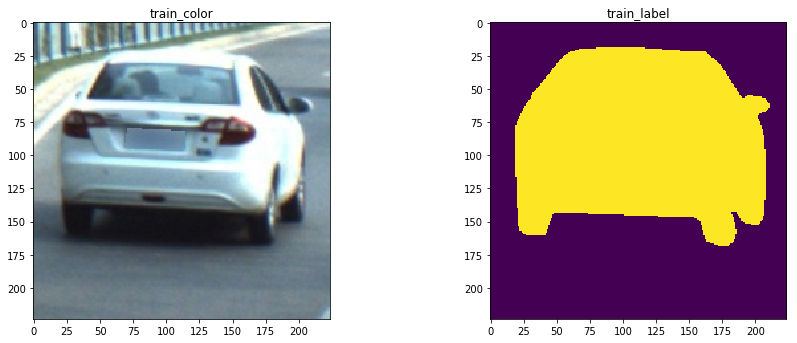

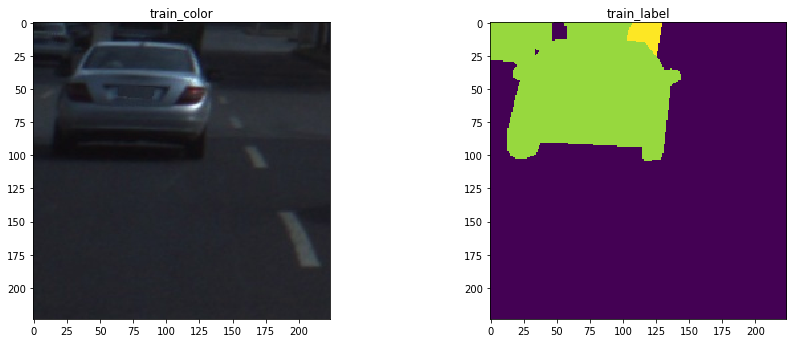

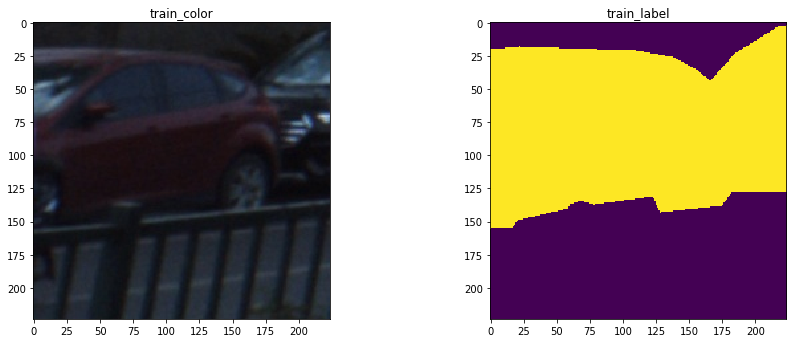

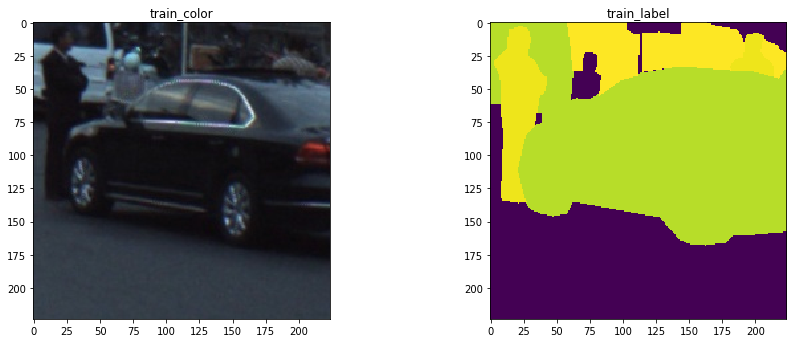

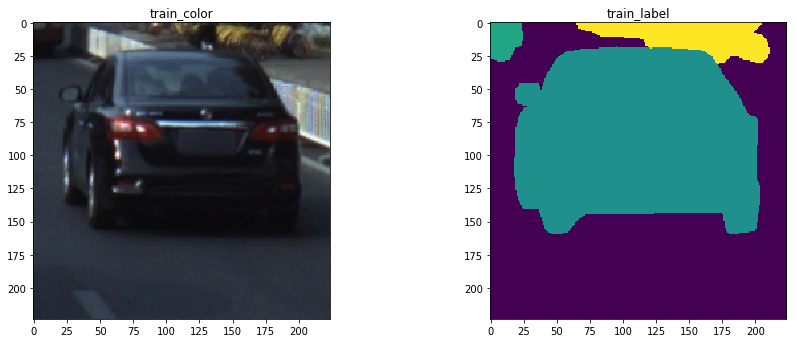

In [6]:
# number of images to plot
n = 5

# obtain "n" random indexes
indxs = np.arange(len(filelist_x))
indx = np.random.choice(indxs, n, replace = False)

for i in range(n):
    #print(filelist_x[indx[i]])
    file_x = np.array(cv2.imread(os.path.join(file_dir, file_dirs_color[3], filelist_x[indx[i]]), -1))/255
    file_y = np.array(cv2.imread(os.path.join(file_dir, file_dirs_label[3], filelist_y[indx[i]]), -1))
    plt.figure(figsize = (15,12))
    plt.subplot(2,2,1)
    plt.imshow(file_x); plt.title('train_color')
    plt.subplot(2,2,2)
    plt.imshow(file_y); plt.title('train_label')
plt.show()

(224, 224, 3)


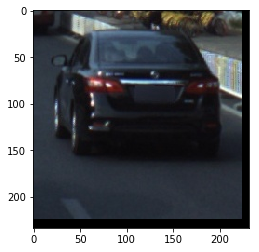

In [7]:
print(file_x.shape)
b = np.pad(file_x,((0,10),(0,8),(0,0)), 'constant', constant_values = 0)
plt.imshow(b)
plt.show()

## Split dataset

Once its tested that the images can be loaded, the dataset will be splitted into training and validation. Only the list of filenames will be splitted.

In [8]:
# split the dataset (filenames)
# x_train, x_val, y_train, y_val = train_test_split(filelist_x,
#                                                   filelist_y,
#                                                   test_size = 0.1,
#                                                   random_state = seed)

## PatchGenerator

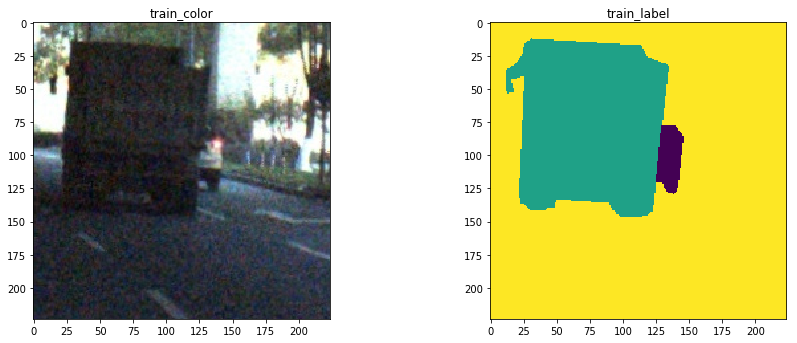

In [9]:
# test the data generator
training_gen = PatchGenerator(
    input_dir       = file_dir, 
    class_labels    = class_labels,
    batch_size      = 8,
    batches         = [32, 128, 224, 416, 1024]
)

for batch_x, batch_y in training_gen:
    # plot first sample
    plt.figure(figsize = (15,12))
    plt.subplot(2,2,1)
    plt.imshow(batch_x[0]); plt.title('train_color')
    plt.subplot(2,2,2)
    plt.imshow(np.argmax(batch_y[0], axis=-1)); plt.title('train_label')
    plt.show()
    break

## Network Training

In [10]:
# since we are going to segment the image, the input should not have any dimension
x_in = Input(shape=(None, None, 3))

vgg_16_new = createVGGskip(x_in)
vgg_16_new = multi_gpu_model(vgg_16_new, gpus = 2)

/home/pabloleo96/MLiP2/create_model.py:201: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ac...)`
  vgg_16_new = Model(input = in_t, output = x_out)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 6 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, None, None, 6 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, None, None, 6 0           block1_conv2[0][0]               
__________________________________________________________________________________________________
block2_con

In [11]:
training_data = PatchGenerator(
    input_dir       = file_dir, 
    class_labels    = class_labels,
    batch_size      = 100,
    batches         = [32, 128, 224]
)

print(training_data.percentages)
print(int(training_data.totalLength//training_data.batch_size))

# compile variables
learning_rate = 0.002 # learning rate
optimizer = Adam(learning_rate) # optimizer
loss_func = 'categorical_crossentropy'
metrics = ['accuracy']

# compile and return the model
vgg_16_new.compile(optimizer, loss_func, metrics)

[0.43315310609028773, 0.4851055678899482, 0.08174132601976405]
5742


In [12]:
# model name
model_name = 'best_model_vgg_8c-testskip.h5'

In [ ]:
# checkpoint to store the best model
checkpoint = ModelCheckpoint(os.path.join(result_dir, model_name),
                             monitor = 'acc', 
                             verbose = 1, 
                             save_best_only = True,
                             save_weights_only = True,
                             mode = 'max', 
                             period = 1)

# stop the model when it doesnt increase the acc
earlystopping = EarlyStopping(monitor = 'acc', 
                              min_delta = 0.03, 
                              patience = 6,
                              verbose = 1, 
                              mode = 'max')

# print results to file
printdata = PrintData()

Epoch 1/300
50/50 [==============================] - 209s 4s/step - loss: 1.7199 - acc: 0.4624

Epoch 00001: acc improved from -inf to 0.46243, saving model to ./results/best_model_vgg_8c-testskip.h5


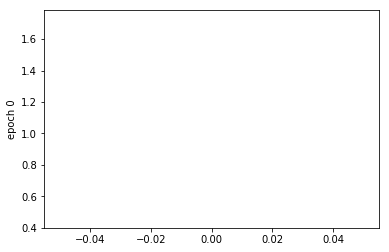

Epoch 2/300
50/50 [==============================] - 191s 4s/step - loss: 1.4467 - acc: 0.5876

Epoch 00002: acc improved from 0.46243 to 0.58758, saving model to ./results/best_model_vgg_8c-testskip.h5


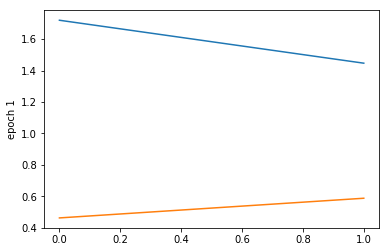

Epoch 3/300
50/50 [==============================] - 182s 4s/step - loss: 1.3417 - acc: 0.6135

Epoch 00003: acc improved from 0.58758 to 0.61345, saving model to ./results/best_model_vgg_8c-testskip.h5


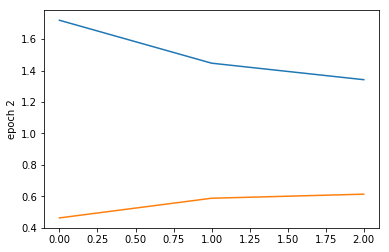

Epoch 4/300
50/50 [==============================] - 186s 4s/step - loss: 1.2598 - acc: 0.6464

Epoch 00004: acc improved from 0.61345 to 0.64642, saving model to ./results/best_model_vgg_8c-testskip.h5


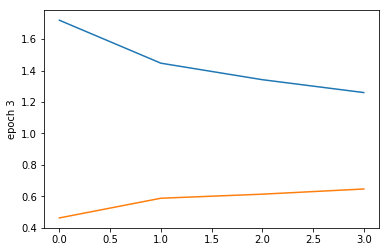

Epoch 5/300
50/50 [==============================] - 185s 4s/step - loss: 1.1970 - acc: 0.6653

Epoch 00005: acc improved from 0.64642 to 0.66530, saving model to ./results/best_model_vgg_8c-testskip.h5


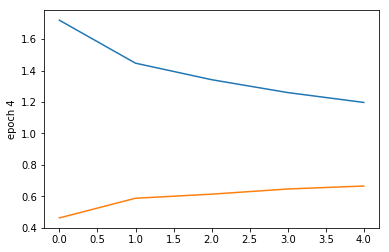

Epoch 6/300
50/50 [==============================] - 181s 4s/step - loss: 1.1549 - acc: 0.6721

Epoch 00006: acc improved from 0.66530 to 0.67208, saving model to ./results/best_model_vgg_8c-testskip.h5


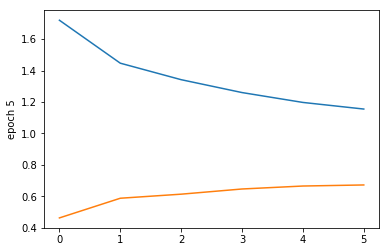

Epoch 7/300
50/50 [==============================] - 180s 4s/step - loss: 1.1243 - acc: 0.6728

Epoch 00007: acc improved from 0.67208 to 0.67282, saving model to ./results/best_model_vgg_8c-testskip.h5


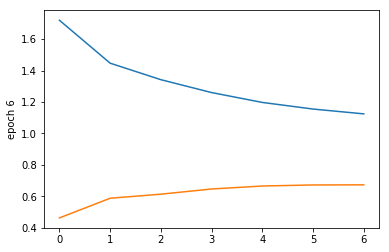

Epoch 8/300
50/50 [==============================] - 181s 4s/step - loss: 1.0837 - acc: 0.6827

Epoch 00008: acc improved from 0.67282 to 0.68267, saving model to ./results/best_model_vgg_8c-testskip.h5


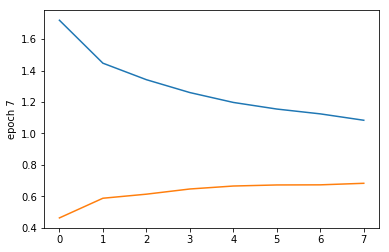

Epoch 9/300
50/50 [==============================] - 188s 4s/step - loss: 1.0488 - acc: 0.6901

Epoch 00009: acc improved from 0.68267 to 0.69012, saving model to ./results/best_model_vgg_8c-testskip.h5


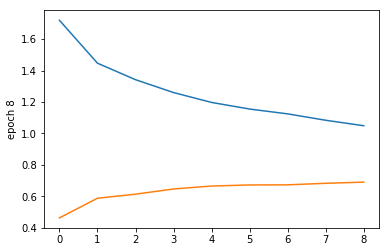

Epoch 10/300
50/50 [==============================] - 181s 4s/step - loss: 1.0283 - acc: 0.6898

Epoch 00010: acc did not improve from 0.69012


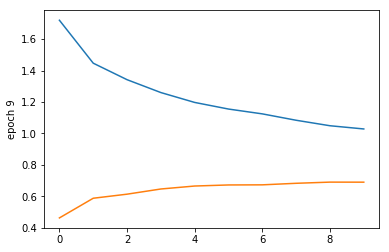

Epoch 11/300
50/50 [==============================] - 179s 4s/step - loss: 1.0059 - acc: 0.6947

Epoch 00011: acc improved from 0.69012 to 0.69467, saving model to ./results/best_model_vgg_8c-testskip.h5


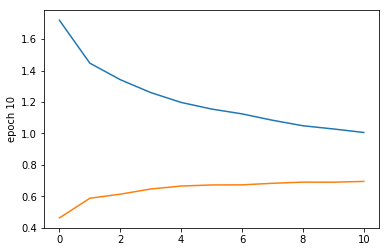

Epoch 12/300
50/50 [==============================] - 176s 4s/step - loss: 1.0007 - acc: 0.6899

Epoch 00012: acc did not improve from 0.69467


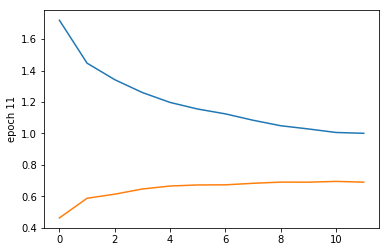

Epoch 13/300
50/50 [==============================] - 180s 4s/step - loss: 0.9720 - acc: 0.6988

Epoch 00013: acc improved from 0.69467 to 0.69878, saving model to ./results/best_model_vgg_8c-testskip.h5


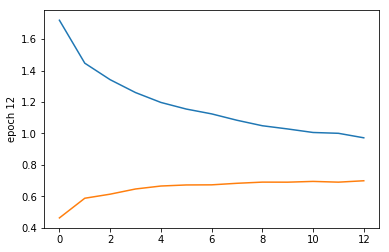

Epoch 14/300
50/50 [==============================] - 177s 4s/step - loss: 0.9551 - acc: 0.6995

Epoch 00014: acc improved from 0.69878 to 0.69945, saving model to ./results/best_model_vgg_8c-testskip.h5


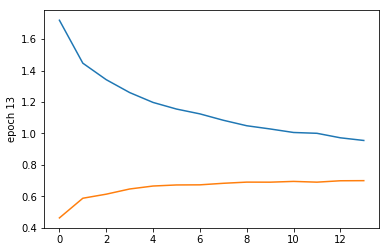

Epoch 15/300
50/50 [==============================] - 176s 4s/step - loss: 0.9534 - acc: 0.6988

Epoch 00015: acc did not improve from 0.69945


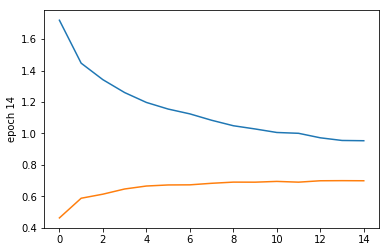

Epoch 16/300
50/50 [==============================] - 168s 3s/step - loss: 0.9358 - acc: 0.7007

Epoch 00016: acc improved from 0.69945 to 0.70070, saving model to ./results/best_model_vgg_8c-testskip.h5


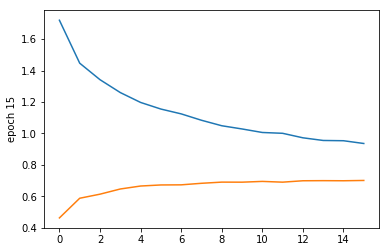

Epoch 17/300
50/50 [==============================] - 167s 3s/step - loss: 0.9245 - acc: 0.7034

Epoch 00017: acc improved from 0.70070 to 0.70343, saving model to ./results/best_model_vgg_8c-testskip.h5


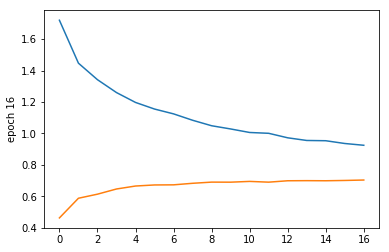

Epoch 18/300
50/50 [==============================] - 172s 3s/step - loss: 0.9182 - acc: 0.7027

Epoch 00018: acc did not improve from 0.70343


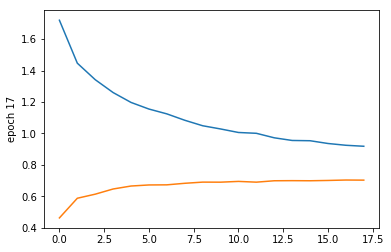

Epoch 19/300
50/50 [==============================] - 173s 3s/step - loss: 0.8850 - acc: 0.7128

Epoch 00019: acc improved from 0.70343 to 0.71279, saving model to ./results/best_model_vgg_8c-testskip.h5


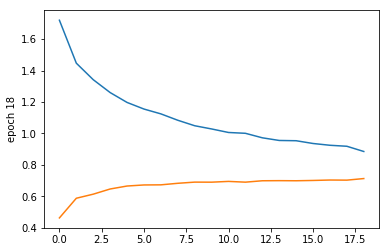

Epoch 20/300
50/50 [==============================] - 169s 3s/step - loss: 0.8789 - acc: 0.7113

Epoch 00020: acc did not improve from 0.71279


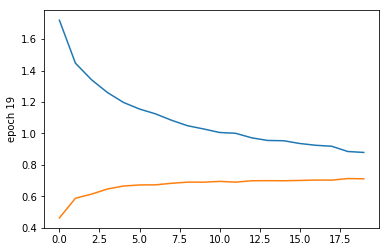

Epoch 21/300
50/50 [==============================] - 169s 3s/step - loss: 0.8953 - acc: 0.7052

Epoch 00021: acc did not improve from 0.71279


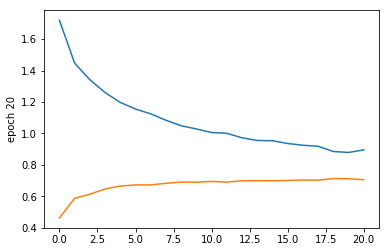

Epoch 22/300
50/50 [==============================] - 169s 3s/step - loss: 0.8843 - acc: 0.7069

Epoch 00022: acc did not improve from 0.71279


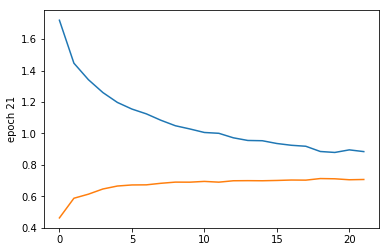

Epoch 23/300
50/50 [==============================] - 162s 3s/step - loss: 0.8909 - acc: 0.7043

Epoch 00023: acc did not improve from 0.71279


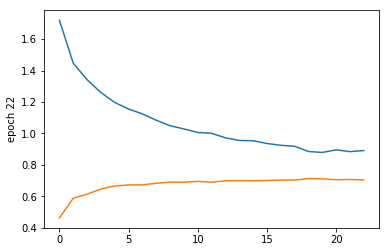

Epoch 24/300
50/50 [==============================] - 160s 3s/step - loss: 0.8621 - acc: 0.7134

Epoch 00024: acc improved from 0.71279 to 0.71339, saving model to ./results/best_model_vgg_8c-testskip.h5


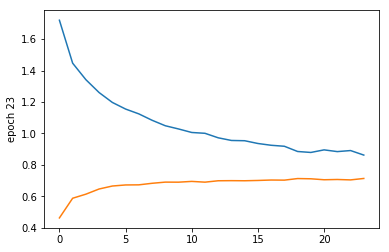

Epoch 25/300
50/50 [==============================] - 155s 3s/step - loss: 0.8836 - acc: 0.7044

Epoch 00025: acc did not improve from 0.71339


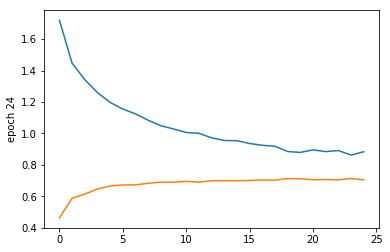

Epoch 26/300
50/50 [==============================] - 155s 3s/step - loss: 0.8764 - acc: 0.7062

Epoch 00026: acc did not improve from 0.71339


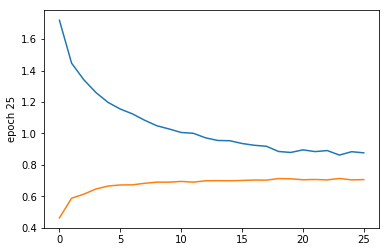

Epoch 27/300
50/50 [==============================] - 152s 3s/step - loss: 0.8522 - acc: 0.7126

Epoch 00027: acc did not improve from 0.71339


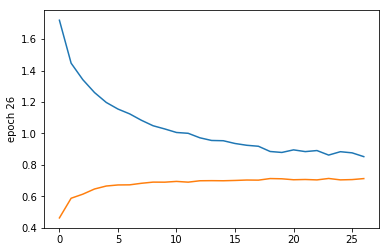

Epoch 28/300
50/50 [==============================] - 154s 3s/step - loss: 0.8521 - acc: 0.7125

Epoch 00028: acc did not improve from 0.71339


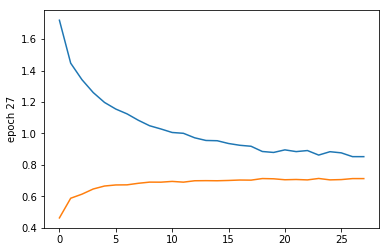

Epoch 29/300
50/50 [==============================] - 149s 3s/step - loss: 0.8569 - acc: 0.7084

Epoch 00029: acc did not improve from 0.71339


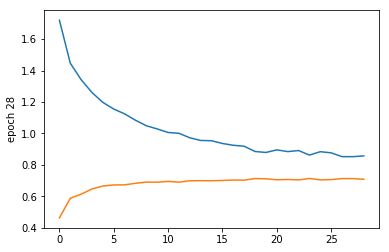

Epoch 30/300
50/50 [==============================] - 144s 3s/step - loss: 0.8574 - acc: 0.7095

Epoch 00030: acc did not improve from 0.71339


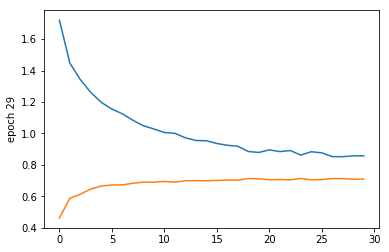

Epoch 31/300
50/50 [==============================] - 148s 3s/step - loss: 0.8114 - acc: 0.7234

Epoch 00031: acc improved from 0.71339 to 0.72342, saving model to ./results/best_model_vgg_8c-testskip.h5


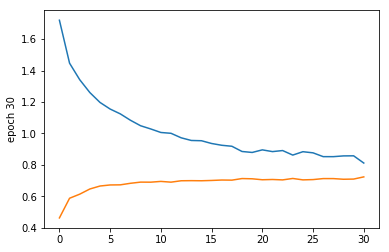

Epoch 32/300
50/50 [==============================] - 150s 3s/step - loss: 0.8536 - acc: 0.7086

Epoch 00032: acc did not improve from 0.72342


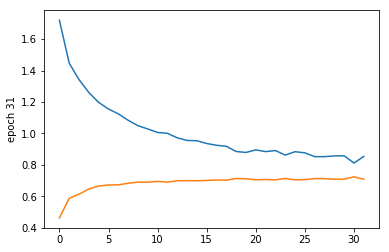

Epoch 33/300
50/50 [==============================] - 147s 3s/step - loss: 0.8479 - acc: 0.7083

Epoch 00033: acc did not improve from 0.72342


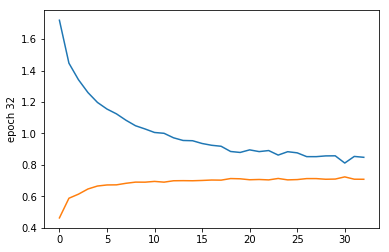

Epoch 34/300
50/50 [==============================] - 148s 3s/step - loss: 0.8209 - acc: 0.7173

Epoch 00034: acc did not improve from 0.72342


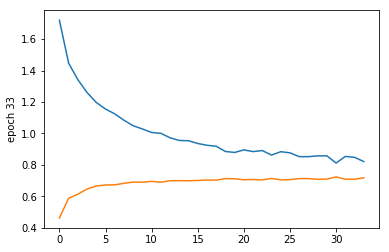

Epoch 35/300
50/50 [==============================] - 148s 3s/step - loss: 0.8378 - acc: 0.7122

Epoch 00035: acc did not improve from 0.72342


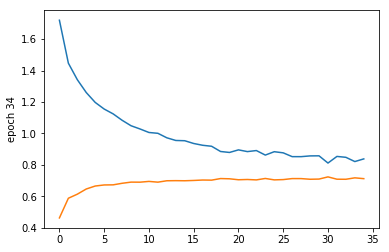

Epoch 36/300
50/50 [==============================] - 148s 3s/step - loss: 0.8271 - acc: 0.7183

Epoch 00036: acc did not improve from 0.72342


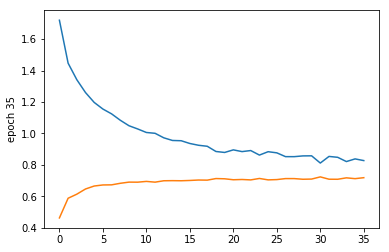

Epoch 37/300
13/50 [======>.......................] - ETA: 1:42 - loss: 0.8456 - acc: 0.7111

In [ ]:
history = vgg_16_new.fit_generator(training_data,
                                   steps_per_epoch = 50,#int(training_data.totalLength//training_data.batch_size),
                                   epochs = 300,
                                   callbacks = [checkpoint, printdata])

In [ ]:
import subprocess
if True:
    print(subprocess.check_output(['sudo', 'shutdown', 'now']))

In [8]:
# obtain a list of files in the given directory
# file_dir_or = './data/king-fish-bucket'
# filelist_x_or = np.array(sorted(os.listdir(os.path.join(file_dir_or, 'train_color'))))
# filelist_y_or = np.array(sorted(os.listdir(os.path.join(file_dir_or, 'train_label'))))


file_dir_or = './data/full_data'
filelist_x_or = np.array(sorted(os.listdir(os.path.join(file_dir_or, 'train_color'))))
filelist_y_or = np.array(sorted(os.listdir(os.path.join(file_dir_or, 'train_label'))))

n = 2

file_x_original = []
file_y_original = []
for i in range(n):
    file_x_original.append(np.pad(np.array(cv2.imread(os.path.join(file_dir_or, 'train_color', filelist_x_or[500+i]), -1))/255,((0,10),(0,8),(0,0)), 'constant', constant_values = 0))
    file_y_original.append(np.pad(np.array(cv2.imread(os.path.join(file_dir_or, 'train_label', filelist_y_or[500+i]), -1)),((0,10),(0,8)), 'constant', constant_values = 0))

    
file_x_original = np.array(file_x_original)
file_y_original = np.array(file_y_original)

file_y_pred = history.model.eval(file_x_original[:,1000:2024,0:2048,:])

#file_y_pred[file_y_pred > 0.4] = 1
#file_y_pred[file_y_pred < 0.4] = 0

for i in range(n):
    plt.figure(figsize = (15,12))
    plt.subplot(2,3,1)
    plt.imshow(file_x_original[i,1000:2024,0:2048,:]); plt.title('original_color')
    plt.subplot(2,3,2)
    plt.imshow(file_y_original[i][1000:2024,0:2048]); plt.title('original_label')
    plt.subplot(2,3,3)
    plt.imshow(np.argmax(file_y_pred[i], axis=-1)); plt.title('predicted_label')
plt.show()

NameError: name 'history' is not defined